## Simulations: BBS v.s. Knockoff/Lasso (TPR,FDR)

### Preparations

In [1]:
import numpy as np
import time
import random
from itertools import product
import matplotlib.pyplot as plt
import numpy.linalg
import numpy.matlib
import warnings
import gurobipy as gp
from gurobipy import GRB
warnings.filterwarnings('ignore')

### Function: Generating Gaussian Samples

In [2]:
def gnrt_normal(n,p,rho,snr,beta0):
    sigma=np.matlib.zeros((p,p))
    for i in range(p):
        for j in range(p):
            sigma[i,j]=rho**(abs(i-j))
    X=np.random.multivariate_normal(mean=np.zeros(p),cov=sigma,size=n)
    var=float(beta0.T.dot(sigma).dot(beta0)/snr)
    I=np.identity(n)
    Y=np.random.multivariate_normal(mean=list(np.array(X.dot(beta0).T)[0]),cov=var*I,size=1)
    return np.matrix(X),np.matrix(Y).T

### Function: Solving Best Subset Selection with $Gurobi$ package

In [3]:
def solve_dis_alg(Y,X,epsilon,k):
    p=X.shape[1]
    L=np.linalg.eig(X.T.dot(X))[0][0]
    beta_old=np.matrix(np.zeros(p)).T
    beta_new=beta_old
    initial=random.sample(range(p),k)
    beta_new[initial,0]=1
    count_iter=0
    while np.linalg.norm(beta_old-beta_new)>epsilon:
        count_iter+=1
        if count_iter>=100000:
            print('Out of Time')
            break
        beta_old=beta_new
        beta_new=np.zeros(p)
        T=np.array(beta_old-1/L*(X.T.dot(X).dot(beta_old)-X.T.dot(Y))).T[0]
        tt_sort=-np.sort(-abs(T))
        for i in range(k):
            for j in range(p):
                if tt_sort[i]==T[j]:
                    beta_new[j]=T[j]
                    break
        beta_new=np.matrix(beta_new).T
    A=[np.flatnonzero(beta_new)]
    active=np.array(np.linalg.inv(X[:,A[0]].T.dot(X[:,A[0]])).dot(X[:,A[0]].T).dot(Y).T)[0]
    beta_warmstart=[0]*p
    j=0
    for i in A[0]:
        beta_warmstart[i]=active[j]
        j=j+1
    return beta_warmstart

def solve_First_Constraint(Y,X,UB):
    p=X.shape[1]
    Quad=np.dot(X.T,X)
    line=np.array(np.dot(Y.T,X))[0]
    entr=float(np.dot(Y.T,Y))
    uppers=[]
    downers=[]
    for i in range(p):
        # Upper
        mvu=gp.Model()
        # Decision variables
        beta=mvu.addVars(p,lb=-GRB.INFINITY,name='beta')
        # Objective function
        mvu.setObjective(beta[i],GRB.MAXIMIZE)
        # Constraint sets
        const=sum(0.5*Quad[k,j]*beta[k]*beta[j] for k,j in product(range(p), repeat=2))
        const-=sum(line[k]*beta[k] for k in range(p))
        const+=0.5*entr
        mvu.addConstr(const<=UB)
        # Solve
        mvu.params.OutputFlag=0
        mvu.params.timelimit=60
        mvu.params.mipgap=0.001
        mvu.optimize()
        uppers.append(mvu.objVal)
        # Lower
        mvL=gp.Model()
        # Decision variables
        beta=mvL.addVars(p,lb=-GRB.INFINITY,name='beta')
        # Objective function
        mvL.setObjective(beta[i],GRB.MINIMIZE)
        # Constraint sets
        const=sum(0.5*Quad[k,j]*beta[k]*beta[j] for k,j in product(range(p), repeat=2))
        const-=sum(line[k]*beta[k] for k in range(p))
        const+=0.5*entr
        mvL.addConstr(const<=UB)
        # Solve
        mvL.params.OutputFlag=0
        mvL.params.timelimit=60
        mvL.params.mipgap=0.001
        mvL.optimize()
        downers.append(mvL.objVal)
    Final_list=[]
    for i in range(p):
        if abs(uppers[i])>abs(downers[i]):
            Final_list.append(abs(uppers[i]))
        else: Final_list.append(abs(downers[i]))
    return max(Final_list),sum(Final_list)
        
def solve_Second_Constraints(Y,X,UB):
    n=X.shape[0]
    Quad=np.dot(X.T,X)
    line=np.array(np.dot(Y.T,X))[0]
    entr=float(np.dot(Y.T,Y))
    uppers=[]
    downers=[]
    for i in range(n):
        # Upper
        mvu=gp.Model()
        # Decision variables
        beta=mvu.addVars(p,lb=-GRB.INFINITY,name='beta')
        # Objective function
        mvu.setObjective(sum(X[i,j]*beta[j] for j in range(p)),GRB.MAXIMIZE)
        # Constraint sets
        const=sum(0.5*Quad[k,j]*beta[k]*beta[j] for k,j in product(range(p), repeat=2))
        const-=sum(line[k]*beta[k] for k in range(p))
        const+=0.5*entr
        mvu.addConstr(const<=UB)
        # Solve
        mvu.params.OutputFlag=0
        mvu.params.timelimit=6000
        mvu.params.mipgap=0.001
        mvu.optimize()
        uppers.append(mvu.objVal)
        # Lower
        mvL=gp.Model()
        # Decision variables
        beta=mvL.addVars(p,lb=-GRB.INFINITY,name='beta')
        # Objective function
        mvL.setObjective(sum(X[i,j]*beta[j] for j in range(p)),GRB.MINIMIZE)
        # Constraint sets
        const=sum(0.5*Quad[k,j]*beta[k]*beta[j] for k,j in product(range(p), repeat=2))
        const-=sum(line[k]*beta[k] for k in range(p))
        const+=0.5*entr
        mvL.addConstr(const<=UB)
        # Solve
        mvL.params.OutputFlag=0
        mvL.params.timelimit=60
        mvL.params.mipgap=0.001
        mvL.optimize()
        downers.append(mvL.objVal)
    Final_list=[]
    for i in range(n):
        if abs(uppers[i])>abs(downers[i]):
            Final_list.append(abs(uppers[i]))
        else: Final_list.append(abs(downers[i]))
    return max(Final_list),sum(Final_list)
    
    
def solve_bestsubset(Y,X,epsilon,k,type=True):
    n,p=X.shape
    beta_warmstart=solve_dis_alg(Y,X,epsilon,k)
    if type:
        UB=(np.linalg.norm(Y))**2
        MU,ML=solve_First_Constraint(Y,X,UB)
        regressor=gp.Model()
        # Decision variables
        beta=regressor.addVars(p,lb=-GRB.INFINITY,name='beta')
        iszero=regressor.addVars(p,vtype=GRB.BINARY,name='iszero')
        L1_beta=regressor.addVars(p,lb=-GRB.INFINITY,name='L1_beta')
        # Objective Function
        Quad=np.dot(X.T,X)
        line=np.array(np.dot(Y.T,X))[0]
        entr=float(np.dot(Y.T,Y))
        obj=sum(0.5*Quad[k,j]*beta[k]*beta[j] for k,j in product(range(p), repeat=2))
        obj-=sum(line[k]*beta[k] for k in range(p))
        obj+=0.5*entr
        regressor.setObjective(obj,GRB.MINIMIZE)
        # Constraint Sets
        for i in range(p):
            regressor.addSOS(GRB.SOS_TYPE1,[beta[i],iszero[i]])
            regressor.addConstr(L1_beta[i]>=0)
            regressor.addConstr(beta[i]<=L1_beta[i])
            regressor.addConstr(beta[i]>=-L1_beta[i])
            regressor.addConstr(beta[i]<=MU)
            regressor.addConstr(beta[i]>=-MU)
        regressor.addConstr(L1_beta.sum()<=ML)
        regressor.addConstr(iszero.sum()==p-k)
        # warm start
        if beta_warmstart is not None and len(beta_warmstart)==p:
            for i in range(p):
                iszero[i].start = (abs(beta_warmstart[i])<1e-6)
        # Solve
        regressor.params.OutputFlag=0
        regressor.params.timelimit=60
        regressor.params.mipgap=0.001
        regressor.optimize()
        betahat=np.array([beta[i].X for i in range(p)])
        return betahat
    else:
        UB=2*(np.linalg.norm(Y))**2
        UB_beta=2*(np.linalg.norm(beta_warmstart))**2
        MU,ML=solve_First_Constraint(Y,X,UB)
        MU_zeta,ML_zeta=solve_Second_Constraints(Y,X,UB)
        regressor=gp.Model()
        # Decision variables
        beta=regressor.addVars(p,lb=-GRB.INFINITY,name='beta')
        zeta=regressor.addVars(n,lb=-GRB.INFINITY,name='zeta')
        iszero=regressor.addVars(p,vtype=GRB.BINARY,name='iszero')
        L1_zeta=regressor.addVars(n,lb=-GRB.INFINITY,name='L1_zeta')
        L1_beta=regressor.addVars(p,lb=-GRB.INFINITY,name='L1_beta')
        #box_zeta=regressor.addVars(n,lb=-GRB.INFINITY,name='box_zeta')
        #box_beta=regressor.addVars(p,lb=-GRB.INFINITY,name='boc_beta')
        # Objective Function
        line=np.dot(Y.T,X)[0]
        entr=np.dot(Y.T,Y)
        obj=sum(zeta[i]*zeta[i] for i in range(n))/2
        obj-=sum(line[k]*beta[k] for k in range(p))
        obj+=0.5*entr
        regressor.setObjective(obj,GRB.MINIMIZE)
        # Constraint Sets
        for i in range(p):
            regressor.addSOS(GRB.SOS_TYPE1,[beta[i],iszero[i]])
            regressor.addConstr(L1_beta[i]>=0)
            regressor.addConstr(beta[i]<=L1_beta[i])
            regressor.addConstr(beta[i]>=-L1_beta[i])
            regressor.addConstr(beta[i]<=MU)
            regressor.addConstr(beta[i]>=-MU)
            regressor.addConstr(beta[i]-beta_warmstart[i]<=box_beta[i])
            regressor.addConstr(beta[i]-beta_warmstart[i]>=-box_beta[i])
        for i in range(n):
            regressor.addConstr(zeta[i]==sum(X[i,j]*beta[j] for j in range(p)))
            regressor.addConstr(L1_zeta[i]>=0)
            regressor.addConstr(zeta[i]<=L1_zeta[i])
            regressor.addConstr(zeta[i]>=-L1_zeta[i])
            regressor.addConstr(zeta[i]<=MU_zeta)
            regressor.addConstr(zeta[i]>=-MU_zeta)
            regressor.addConstr(zeta[i]-sum(X[i,j]*beta_warmstart[j] for j in range(p))>=-box_zeta[i])
            regressor.addConstr(zeta[i]-sum(X[i,j]*beta_warmstart[j] for j in range(p))<=box_zeta[i])
        regressor.addConstr(L1_zeta.sum()<=ML_zeta)
        regressor.addConstr(L1_beta.sum()<=ML)
        regressor.addConstr(box_beta.sum()<=UB_beta)
        regressor.addConstr(box_zeta.sum()<=UB)
        regressor.addConstr(iszero.sum()==p-k)
        # warm start
        if beta_warmstart is not None and len(beta_warmstart)==p:
            for i in range(p):
                iszero[i].start = (abs(beta_warmstart[i])<1e-6)
        # Solve
        regressor.params.OutputFlag=0
        regressor.params.timelimit=60
        regressor.params.mipgap=0.001
        regressor.optimize()
        betahat=np.array([beta[i].X for i in range(p)])
        return betahat
    
# Another BSS
def solve_simple_bss(Y,X,epsilon,k):
    n,p=X.shape
    beta_warmstart=solve_dis_alg(Y,X,epsilon,k)
    regressor=gp.Model()
    # Decision variables
    beta=regressor.addVars(p,lb=-GRB.INFINITY,name='beta')
    zeta=regressor.addVars(n,lb=-GRB.INFINITY,name='zeta')
    iszero=regressor.addVars(p,vtype=GRB.BINARY,name='iszero')
    # Objective Function
    line=np.array(np.dot(Y.T,X))[0]
    entr=np.dot(Y.T,Y)
    obj=sum(zeta[i]*zeta[i] for i in range(n))/2
    obj-=sum(line[k]*beta[k] for k in range(p))
    obj+=0.5*entr
    regressor.setObjective(obj,GRB.MINIMIZE)
    # Constraint Sets
    for i in range(p):
        regressor.addSOS(GRB.SOS_TYPE1,[beta[i],iszero[i]])
    for i in range(n):
        regressor.addConstr(zeta[i]==sum(X[i,j]*beta[j] for j in range(p)))
    regressor.addConstr(iszero.sum()==p-k)
    # warm start
    if beta_warmstart is not None and len(beta_warmstart)==p:
        for i in range(p):
            iszero[i].start = (abs(beta_warmstart[i])<1e-6)
    # Solve
    regressor.params.OutputFlag=0
    regressor.params.timelimit=60
    regressor.params.mipgap=0.001
    regressor.optimize()
    betahat=np.array([beta[i].X for i in range(p)])
    return betahat

### Function: Solving $Lasso$

In [4]:
def Lasso(Y,X,nu):
    lambd=np.linalg.norm(Y)*nu
    n=X.shape[0]
    p=X.shape[1]
    beta_old=np.matrix(np.zeros(p)).T
    beta_new=np.matrix(np.ones(p)).T
    while (beta_new-beta_old).T.dot(beta_new-beta_old)>0.01:
        beta_old=beta_new
        beta_new=np.zeros(p)
        for j in range(p):
            rho=0
            for i in range(n):
                rho+=X[i,j]*(Y[i]-X[i,].dot(beta_old)+X[i,j]*beta_old[j])
            z=X[:,j].T.dot(X[:,j])
            if rho<-lambd/2: 
                beta_new[j]=(rho+lambd/2)/z
            elif rho>=-lambd/2 and rho<=lambd/2:
                beta_new[j]=0
            elif rho>lambd/2:
                beta_new[j]=(rho-lambd/2)/z
        beta_new=np.matrix(beta_new).T
    return list(np.array(beta_new.T)[0])

### Function: Metrics--FDR,TPR

In [5]:
def FDR(betahat,beta0):
    p=len(list(beta0))
    if np.flatnonzero(betahat).shape[0]==0:
        print('False prediction!')
        return
    score=0
    for i in range(p):
        if betahat[i]!=0 and beta0[i]==0:
            score=score+1
    return score/(np.flatnonzero(betahat).shape[0])
def TPR(betahat,beta0):
    p=len(list(beta0))
    score=0
    for i in range(p):
        if betahat[i]!=0 and beta0[i]!=0:
            score=score+1
    return score/(np.flatnonzero(beta0).shape[0])

### Test BSS

### Test Lasso

In [17]:
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(5)))).T
X,Y=gnrt_normal(100,10,0.35,10,beta0)
beta_lasso=Lasso(Y,X,1)
print(beta_lasso)

KeyboardInterrupt: 

### Test Plot 

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


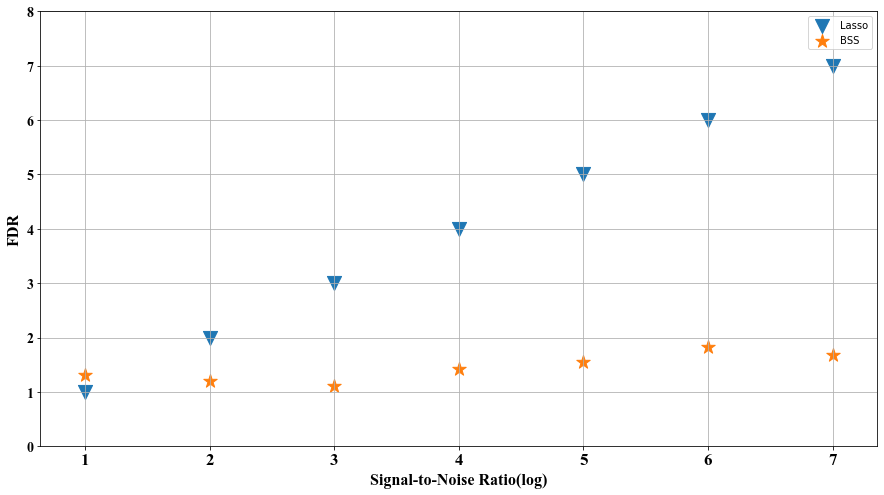

In [6]:
a=np.linspace(0.1,0.6,7)
print(type(a))
e=[3,2,1,4,5,7,6]
b=[0.1,0.2,0.3,0.1,0.2,0.1,0.1]
print(type(np.array(b)))
c=np.exp(a)
d=[3,2,1,4,5,7,6]
f=np.sort(d)
plt.figure(figsize=(15, 8))
plt.scatter(e,d,s=200,marker='v',label='Lasso')
plt.scatter(e,c,s=200,marker='*',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,8))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('Signal-to-Noise Ratio(log)',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

### Actual Tests

In [7]:
# Set k levels
klow=[1,2,3,4,5,6,7,8,9,10]
kmed=[1,2,3,4,5,7,9,11,15,20]
# Set $\nu$ levels

#### Test1: Low Setting, High-Noise, $\rho$ = 0.35

In [8]:
# BSS
# Store FDR and TPR
TPR_1=[]
FDR_1=[]
# Set generate parameters 
n=100
p=50
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(45)))).T
snr=10**0.05
rho=0.35
# Test
for i in range(10):
    TPR_1_temp=[]
    FDR_1_temp=[]
    for j in range(10):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.01,klow[i])
            if len(beta_bestsubset)>0:
                TPR_1_temp.append(TPR(beta_bestsubset,beta0))
                FDR_1_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_1.append(np.mean(TPR_1_temp))
    FDR_1.append(np.mean(FDR_1_temp))
    print(i,end=' ')
print('\n')
print('FDR_1:',FDR_1)
print('TPR_1:',TPR_1)

Using license file C:\Users\user\gurobi.lic
Academic license - for non-commercial use only
0 1 2 3 4 5 6 7 8 9 

FDR_1: [0.0, 0.0, 0.0, 0.075, 0.28, 0.2833333333333333, 0.45714285714285713, 0.525, 0.5333333333333334, 0.54]
TPR_1: [0.2, 0.4, 0.5999999999999999, 0.74, 0.72, 0.8600000000000001, 0.76, 0.76, 0.8400000000000001, 0.9199999999999999]


In [21]:
# Lasso


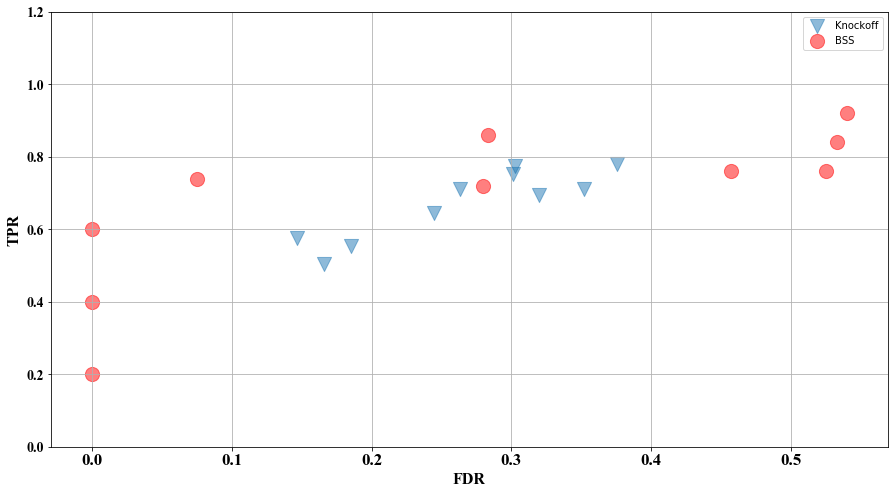

In [32]:
# Plot
FDR_1_knock=[0.147,0.166,0.185,0.245,0.303,0.301,0.263,0.320,0.352,0.376]
TPR_1_knock=[0.576,0.504,0.554,0.646,0.774,0.752,0.712,0.696,0.710,0.78]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_1_knock,TPR_1_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_1,TPR_1,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

#### Test2: Low Setting, High-Noise, $\rho$ = 0.70

In [9]:
# BSS
# Store FDR and TPR
TPR_2=[]
FDR_2=[]
# Set generate parameters 
n=100
p=50
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(45)))).T
snr=10**0.05
rho=0.7
# Test
for i in range(10):
    TPR_2_temp=[]
    FDR_2_temp=[]
    for j in range(10):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.01,klow[i])
            if len(beta_bestsubset)>0:
                TPR_2_temp.append(TPR(beta_bestsubset,beta0))
                FDR_2_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_2.append(np.mean(TPR_2_temp))
    FDR_2.append(np.mean(FDR_2_temp))
    print(i,end=' ')
print('\n')
print('FDR_2:',FDR_2)
print('TPR_2:',TPR_2)

0 1 2 3 4 5 6 7 8 9 

FDR_2: [0.0, 0.05, 0.16666666666666666, 0.425, 0.4600000000000001, 0.4833333333333334, 0.6142857142857142, 0.675, 0.6444444444444445, 0.7]
TPR_2: [0.2, 0.38, 0.5, 0.45999999999999996, 0.5399999999999999, 0.6200000000000001, 0.54, 0.52, 0.6399999999999999, 0.6]


In [ ]:
# Lasso

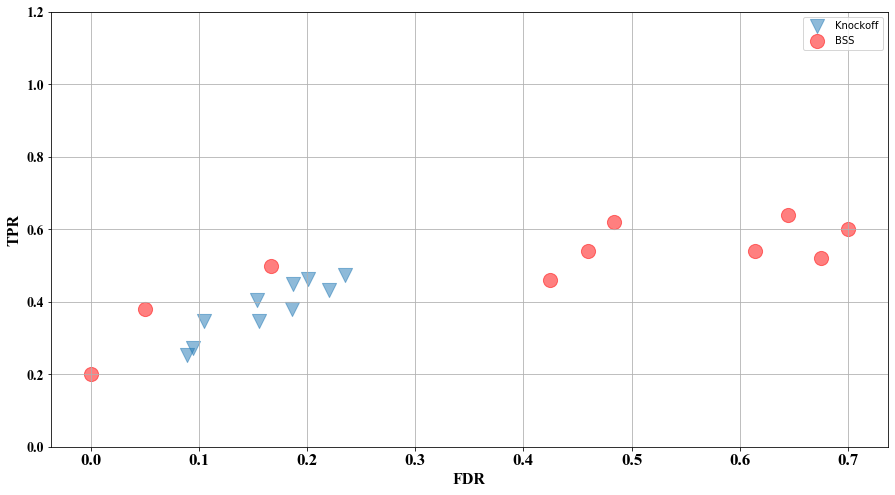

In [33]:
# Plot
FDR_2_knock=[0.08886,0.0948,0.1053,0.1554,0.1875,0.15426,0.1863,0.2007,0.2206,0.23535]
TPR_2_knock=[0.254,0.272,0.348,0.346,0.450,0.406,0.380,0.464,0.434,0.474]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_2_knock,TPR_2_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_2,TPR_2,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

#### Test3: Low Setting, Medium-Noise, $\rho$ = 0.35

In [10]:
# BSS
# Store FDR and TPR
TPR_3=[]
FDR_3=[]
# Set generate parameters 
n=100
p=50
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(45)))).T
snr=10
rho=0.35
# Test
for i in range(10):
    TPR_3_temp=[]
    FDR_3_temp=[]
    for j in range(10):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.01,klow[i])
            if len(beta_bestsubset)>0:
                TPR_3_temp.append(TPR(beta_bestsubset,beta0))
                FDR_3_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_3.append(np.mean(TPR_3_temp))
    FDR_3.append(np.mean(FDR_3_temp))
    print(i,end=' ')
print('\n')
print('FDR_3:',FDR_3)
print('TPR_3:',TPR_3)

0 1 2 3 4 5 6 7 8 9 

FDR_3: [0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666669, 0.2857142857142857, 0.375, 0.4444444444444445, 0.5]
TPR_3: [0.2, 0.4, 0.5999999999999999, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Lasso

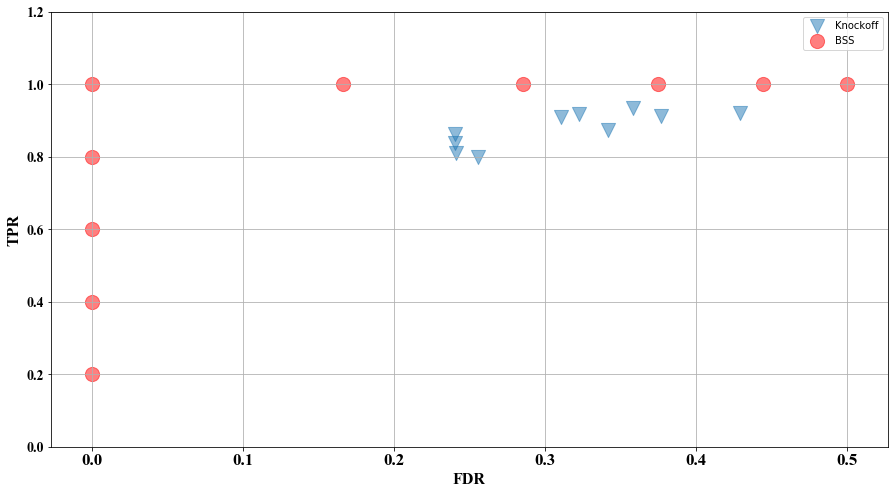

In [34]:
# Plot
FDR_3_knock=[0.24121,0.24068,0.24037,0.25581,0.3421046,0.3107,0.3228156,0.37722075,0.3582164,0.4291967]
TPR_3_knock=[0.812,0.838,0.862,0.8,0.874,0.910,0.918,0.914,0.936,0.922]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_3_knock,TPR_3_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_3,TPR_3,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

#### Test4: Low Setting, Medium-Noise, $\rho$ = 0.70

In [11]:
# BSS
# Store FDR and TPR
TPR_4=[]
FDR_4=[]
# Set generate parameters 
n=100
p=50
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(45)))).T
snr=10
rho=0.7
# Test
for i in range(10):
    TPR_4_temp=[]
    FDR_4_temp=[]
    for j in range(10):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.0001,klow[i])
            if len(beta_bestsubset)>0:
                TPR_4_temp.append(TPR(beta_bestsubset,beta0))
                FDR_4_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_4.append(np.mean(TPR_4_temp))
    FDR_4.append(np.mean(FDR_4_temp))
    print(i,end=' ')
print('\n')
print('FDR_4:',FDR_4)
print('TPR_4:',TPR_4)

0 1 2 3 4 5 6 7 8 9 

FDR_4: [0.0, 0.0, 0.0, 0.0, 0.02, 0.16666666666666669, 0.2857142857142857, 0.3875, 0.4444444444444445, 0.5]
TPR_4: [0.2, 0.4, 0.5999999999999999, 0.8, 0.9800000000000001, 1.0, 1.0, 0.9800000000000001, 1.0, 1.0]


In [ ]:
# Lasso

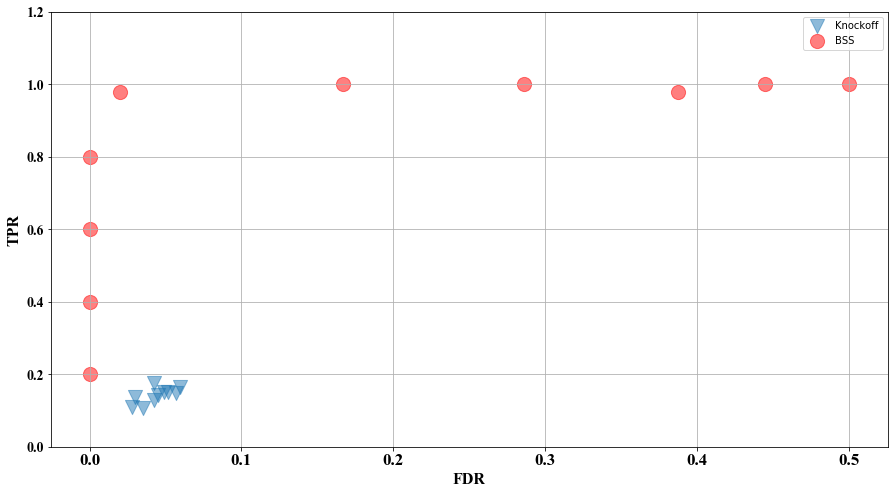

In [36]:
# Plot
FDR_4_knock=[0.02821429,0.03508,0.04237,0.042434,0.05169,0.0299,0.04507488,0.048937,0.059584,0.05658009]
TPR_4_knock=[0.11,0.106,0.176,0.130,0.150,0.138,0.144,0.152,0.164,0.148]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_4_knock,TPR_4_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_4,TPR_4,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

#### Test5: Low Setting, Low-Noise, $\rho$ = 0.35

In [12]:
# BSS
# Store FDR and TPR
TPR_5=[]
FDR_5=[]
# Set generate parameters 
n=100
p=50
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(45)))).T
snr=10**6
rho=0.35
# Test
for i in range(10):
    TPR_5_temp=[]
    FDR_5_temp=[]
    for j in range(10):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.0001,klow[i])
            if len(beta_bestsubset)>0:
                TPR_5_temp.append(TPR(beta_bestsubset,beta0))
                FDR_5_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_5.append(np.mean(TPR_5_temp))
    FDR_5.append(np.mean(FDR_5_temp))
    print(i,end=' ')
print('\n')
print('FDR_5:',FDR_5)
print('TPR_5:',TPR_5)

0 1 2 3 4 5 6 7 8 9 

FDR_5: [0.0, 0.0, 0.0, 0.0, 0.16964285714285712, 0.16666666666666669, 0.3214285714285714, 0.44305555555555554, 0.5, 0.5568181818181818]
TPR_5: [0.2, 0.4, 0.5999999999999999, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Lasso

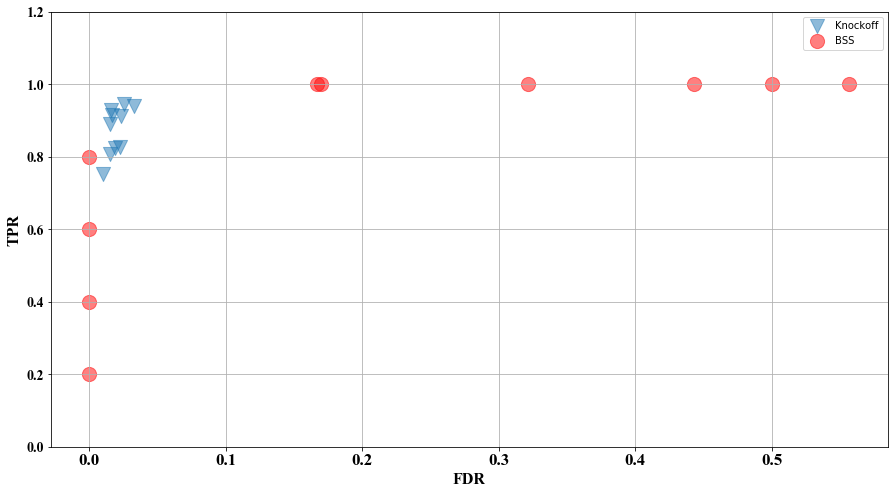

In [38]:
# Plot
FDR_5_knock=[0.02208,0.01,0.0152,0.01845,0.01608,0.01485,0.02304,0.01694048,0.02533,0.032523]
TPR_5_knock=[0.826,0.752,0.808,0.824,0.928,0.890,0.912,0.916,0.946,0.94]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_5_knock,TPR_5_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_5,TPR_5,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

#### Test6: Low Setting, Low-Noise, $\rho$ = 0.70

In [13]:
# BSS
# Store FDR and TPR
TPR_6=[]
FDR_6=[]
# Set generate parameters 
n=100
p=50
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(45)))).T
snr=10**6
rho=0.7
# Test
for i in range(10):
    TPR_6_temp=[]
    FDR_6_temp=[]
    for j in range(10):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.0001,klow[i])
            if len(beta_bestsubset)>0:
                TPR_6_temp.append(TPR(beta_bestsubset,beta0))
                FDR_6_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_6.append(np.mean(TPR_6_temp))
    FDR_6.append(np.mean(FDR_6_temp))
    print(i,end=' ')
print('\n')
print('FDR_6:',FDR_6)
print('TPR_6:',TPR_6)

0 1 2 3 4 5 6 7 8 9 

FDR_6: [0.0, 0.0, 0.0, 0.0, 0.05714285714285714, 0.16666666666666669, 0.2857142857142857, 0.46565656565656566, 0.498989898989899, 0.5568181818181818]
TPR_6: [0.2, 0.4, 0.5999999999999999, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Lasso

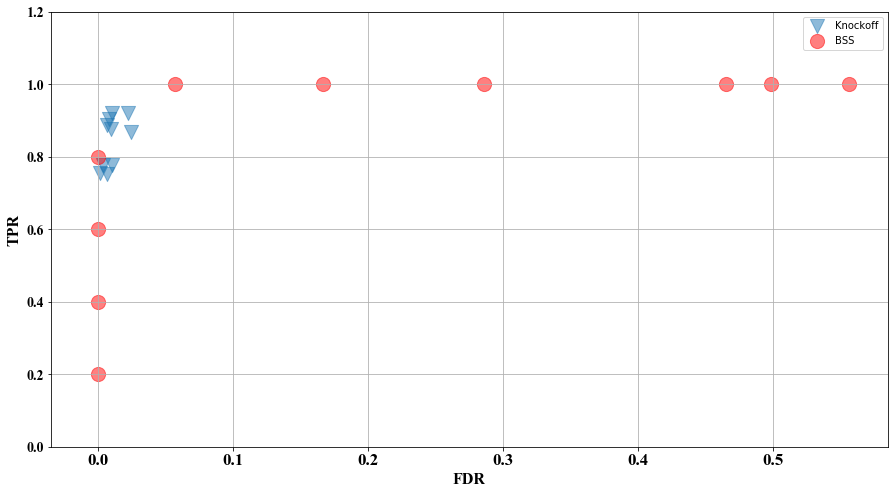

In [40]:
# Plot
FDR_6_knock=[0.00167,0.003333,0.007,0.010190476,0.0106667,0.006523810,0.009761,0.02425641,0.007857143,0.02213]
TPR_6_knock=[0.756,0.778,0.754,0.778,0.922,0.888,0.876,0.870,0.904,0.920]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_6_knock,TPR_6_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_6,TPR_6,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

#### Test7: Medium Setting, High-Noise, $\rho$ = 0.35

In [15]:
# BSS
# Store FDR and TPR
TPR_7=[]
FDR_7=[]
# Set generate parameters 
n=500
p=100
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(95)))).T
snr=10**0.05
rho=0.35
# Test
for i in range(10):
    TPR_7_temp=[]
    FDR_7_temp=[]
    for j in range(3):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.000001,kmed[i])
            if len(beta_bestsubset)>0:
                TPR_7_temp.append(TPR(beta_bestsubset,beta0))
                FDR_7_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_7.append(np.mean(TPR_7_temp))
    FDR_7.append(np.mean(FDR_7_temp))
    print(i,end=' ')
print('\n')
print('FDR_7:',FDR_7)
print('TPR_7:',TPR_7)

0 1 2 3 4 5 6 7 8 9 

FDR_7: [0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.2857142857142857, 0.4444444444444444, 0.5454545454545454, 0.6666666666666666, 0.75]
TPR_7: [0.20000000000000004, 0.4000000000000001, 0.6, 0.8000000000000002, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Lasso

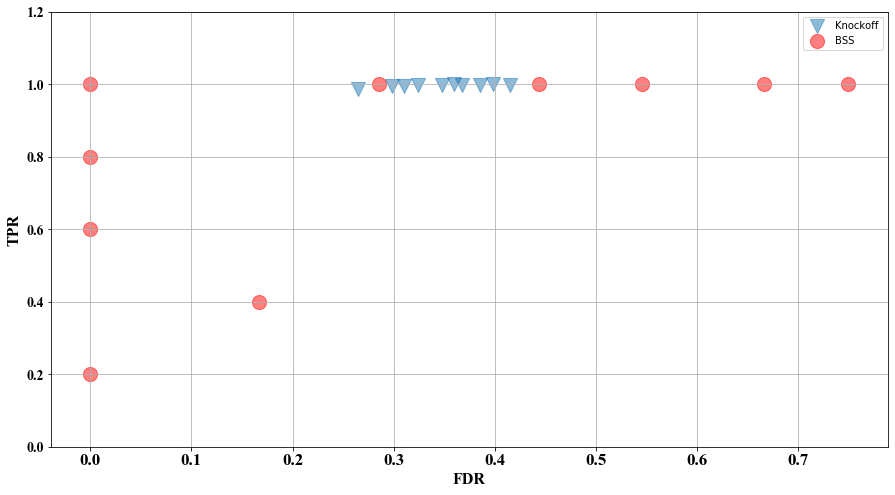

In [41]:
# Plot
FDR_7_knock=[0.26492,0.2989332,0.3107872,0.3244861,0.3851247,0.3680117,0.3476537,0.3602411,0.3983052,0.4154519]
TPR_7_knock=[0.986,0.996,0.996,0.998,0.998,0.998,0.998,1,1,0.998]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_7_knock,TPR_7_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_7,TPR_7,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

#### Test8: Medium Setting, High-Noise, $\rho$ = 0.70

In [16]:
# BSS
# Store FDR and TPR
TPR_8=[]
FDR_8=[]
# Set generate parameters 
n=500
p=100
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(95)))).T
snr=10**0.05
rho=0.7
# Test
for i in range(10):
    TPR_8_temp=[]
    FDR_8_temp=[]
    for j in range(3):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.000001,kmed[i])
            if len(beta_bestsubset)>0:
                TPR_8_temp.append(TPR(beta_bestsubset,beta0))
                FDR_8_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_8.append(np.mean(TPR_8_temp))
    FDR_8.append(np.mean(FDR_8_temp))
    print(i,end=' ')
print('\n')
print('FDR_8:',FDR_8)
print('TPR_8:',TPR_8)

0 1 2 3 4 5 6 7 8 9 

FDR_8: [0.0, 0.0, 0.0, 0.0, 0.20000000000000004, 0.2857142857142857, 0.4444444444444444, 0.5757575757575757, 0.6666666666666666, 0.75]
TPR_8: [0.20000000000000004, 0.4000000000000001, 0.6, 0.8000000000000002, 0.8000000000000002, 1.0, 1.0, 0.9333333333333332, 1.0, 1.0]


In [ ]:
# Lasso

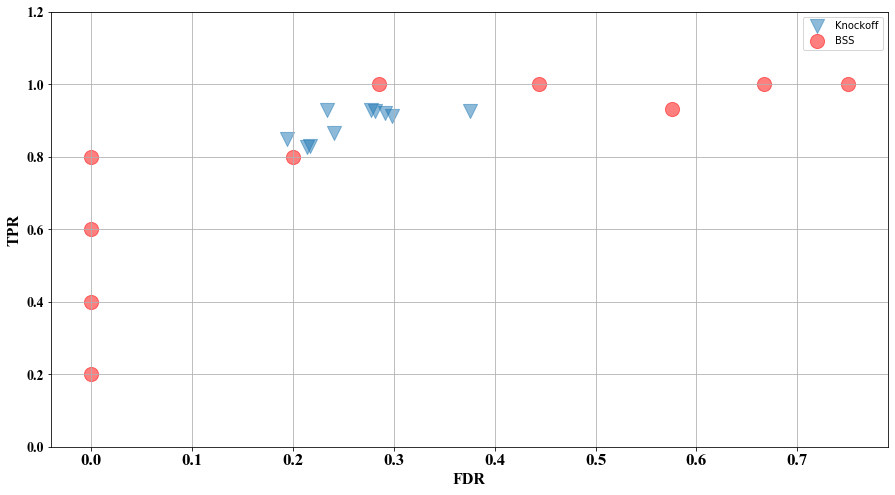

In [42]:
# Plot
FDR_8_knock=[0.2139,0.2168,0.2410,0.1940,0.2341,0.2913,0.2780,0.3759,0.2987,0.2811]
TPR_8_knock=[0.826,0.830,0.866,0.848,0.930,0.920,0.928,0.926,0.912,0.926]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_8_knock,TPR_8_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_8,TPR_8,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

#### Test9: Medium Setting, Medium-Noise, $\rho$ = 0.35

In [17]:
# BSS
# Store FDR and TPR
TPR_9=[]
FDR_9=[]
# Set generate parameters 
n=500
p=100
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(95)))).T
snr=10
rho=0.35
# Test
for i in range(10):
    TPR_9_temp=[]
    FDR_9_temp=[]
    for j in range(2):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.000001,kmed[i])
            if len(beta_bestsubset)>0:
                TPR_9_temp.append(TPR(beta_bestsubset,beta0))
                FDR_9_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_9.append(np.mean(TPR_9_temp))
    FDR_9.append(np.mean(FDR_9_temp))
    print(i,end=' ')
print('\n')
print('FDR_9:',FDR_9)
print('TPR_9:',TPR_9)

0 1 2 3 4 5 6 7 8 9 

FDR_9: [0.0, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, 0.4444444444444444, 0.5454545454545454, 0.6666666666666666, 0.75]
TPR_9: [0.2, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Lasso

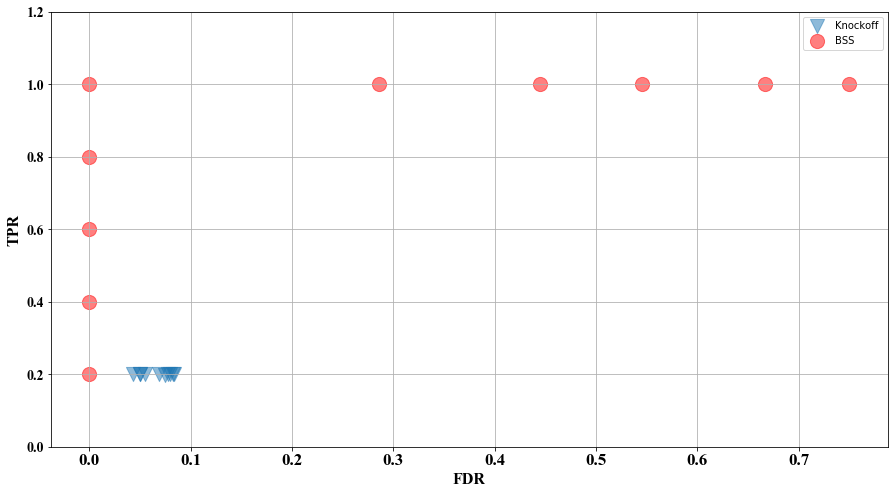

In [43]:
# Plot
FDR_9_knock=[0.043,0.055,0.05,0.069,0.083,0.08,0.05,0.07745,0.0751,0.0831]
TPR_9_knock=[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.198,0.2]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_9_knock,TPR_9_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_9,TPR_9,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

#### Test10: Medium Setting, Medium-Noise, $\rho$ = 0.70

In [18]:
# BSS
# Store FDR and TPR
TPR_10=[]
FDR_10=[]
# Set generate parameters 
n=500
p=100
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(95)))).T
snr=10
rho=0.7
# Test
for i in range(10):
    TPR_10_temp=[]
    FDR_10_temp=[]
    for j in range(2):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.000001,kmed[i])
            if len(beta_bestsubset)>0:
                TPR_10_temp.append(TPR(beta_bestsubset,beta0))
                FDR_10_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_10.append(np.mean(TPR_10_temp))
    FDR_10.append(np.mean(FDR_10_temp))
    print(i,end=' ')
print('\n')
print('FDR_10:',FDR_10)
print('TPR_10:',TPR_10)

0 1 2 3 4 5 6 7 8 9 

FDR_10: [0.0, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, 0.4444444444444444, 0.5454545454545454, 0.6666666666666666, 0.75]
TPR_10: [0.2, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Lasso

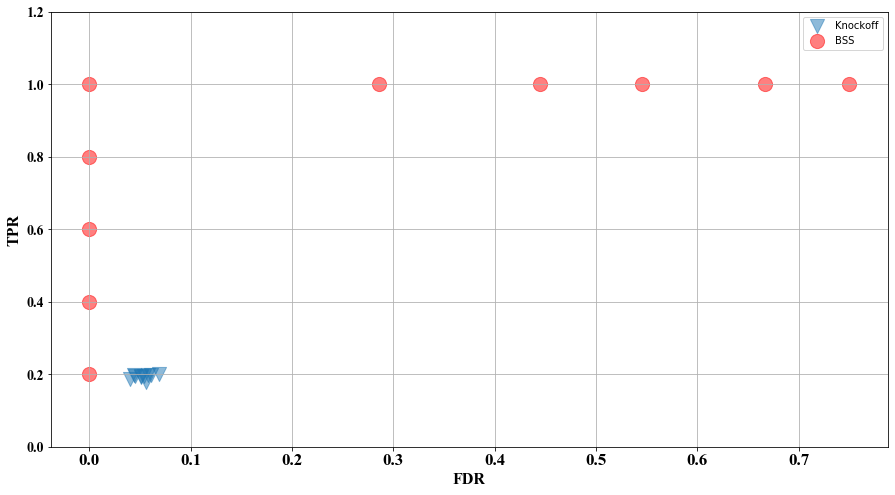

In [44]:
# Plot
FDR_10_knock=[0.04,0.045448,0.056242,0.06063,0.05767,0.05409325,0.05121175,0.0509347,0.04373431,0.0688489]
TPR_10_knock=[0.188,0.194,0.178,0.198,0.198,0.196,0.194,0.192,0.198,0.2]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_10_knock,TPR_10_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_10,TPR_10,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

#### Test1: Medium Setting, Low-Noise, $\rho$ = 0.35

In [19]:
# BSS
# Store FDR and TPR
TPR_11=[]
FDR_11=[]
# Set generate parameters 
n=500
p=100
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(95)))).T
snr=10**6
rho=0.35
# Test
for i in range(10):
    TPR_11_temp=[]
    FDR_11_temp=[]
    for j in range(2):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.000001,kmed[i])
            if len(beta_bestsubset)>0:
                TPR_11_temp.append(TPR(beta_bestsubset,beta0))
                FDR_11_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_11.append(np.mean(TPR_11_temp))
    FDR_11.append(np.mean(FDR_11_temp))
    print(i,end=' ')
print('\n')
print('FDR_11:',FDR_11)
print('TPR_11:',TPR_11)

0 1 2 3 4 5 6 7 8 9 

FDR_11: [0.0, 0.0, 0.0, 0.0, 0.375, 0.375, 0.5416666666666667, 0.5833333333333334, 0.6862745098039216, 0.7613636363636364]
TPR_11: [0.2, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Lasso

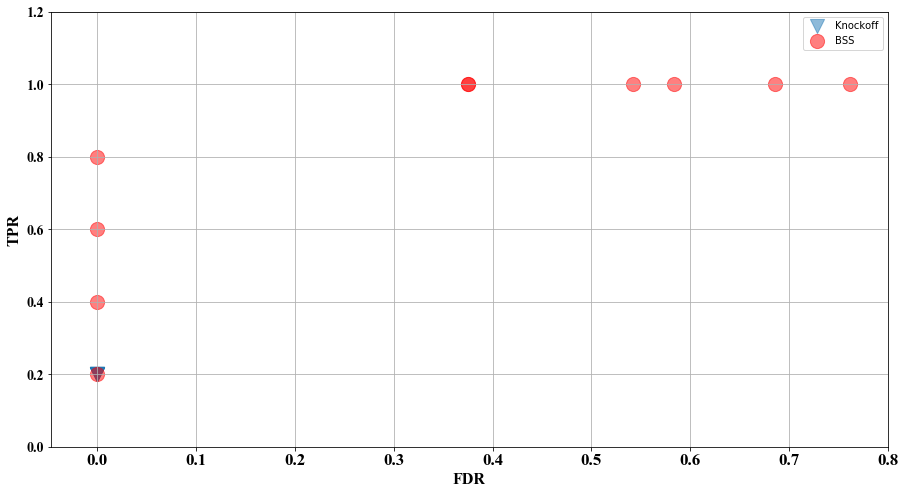

In [45]:
# Plot
FDR_11_knock=[0,0,0,0,0,0,0,0,0,0]
TPR_11_knock=[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_11_knock,TPR_11_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_11,TPR_11,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()

#### Test12: Meidum Setting, Low-Noise, $\rho$ = 0.70

In [20]:
# BSS
# Store FDR and TPR
TPR_12=[]
FDR_12=[]
# Set generate parameters 
n=500
p=100
beta0=np.matrix(np.array(list(np.ones(5))+list(np.zeros(95)))).T
snr=10**6
rho=0.7
# Test
for i in range(10):
    TPR_12_temp=[]
    FDR_12_temp=[]
    for j in range(2):
        X,Y=gnrt_normal(n,p,rho,snr,beta0)
        try:
            beta_bestsubset=solve_bestsubset(Y,X,0.000001,kmed[i])
            if len(beta_bestsubset)>0:
                TPR_12_temp.append(TPR(beta_bestsubset,beta0))
                FDR_12_temp.append(FDR(beta_bestsubset,beta0))
        except AttributeError:
            print('F')
    TPR_12.append(np.mean(TPR_12_temp))
    FDR_12.append(np.mean(FDR_12_temp))
    print(i,end=' ')
print('\n')
print('FDR_12:',FDR_12)
print('TPR_12:',TPR_12)

0 1 2 3 4 5 6 7 8 9 

FDR_12: [0.0, 0.0, 0.0, 0.0, 0.2222222222222222, 0.375, 0.5227272727272727, 0.6153846153846154, 0.6862745098039216, 0.7559523809523809]
TPR_12: [0.2, 0.4, 0.6, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# Lasso

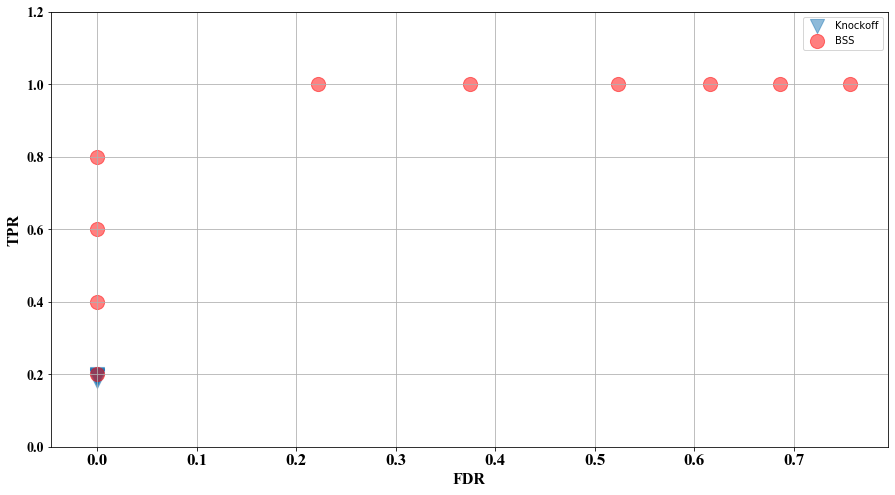

In [47]:
# Plot
FDR_12_knock=[0,0,0,0,0,0,0,0,0,0]
TPR_12_knock=[0.198,0.196,0.182,0.186,0.194,0.192,0.192,0.194,0.2,0.198]
plt.figure(figsize=(15, 8))
plt.scatter(FDR_12_knock,TPR_12_knock,alpha=0.5,s=200,marker='v',label='Knockoff')
plt.scatter(FDR_12,TPR_12,s=200,alpha=0.5,c='r',marker='o',label='BSS')
plt.legend(loc='upper right')
plt.ylim((0,1.2))
plt.xticks(fontproperties='Times New Roman',size=17)
plt.yticks(fontproperties='Times New Roman',size=14)
plt.xlabel('FDR',fontdict={'family':'Times New Roman','size':16})
plt.ylabel('TPR',fontdict={'family':'Times New Roman','size':16})
plt.grid(True)
plt.show()